# Predicting Car Prices

# ------------------------- Task 1-----------------------------

#### Importing Libraries

In [103]:
import re
import warnings
import numpy as np
import pandas as pd
import joblib as jl
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## 1. Load Data

In [104]:
df = pd.read_csv("Cars.csv")

In [105]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.00


In [106]:
df.shape

(8128, 13)

In [107]:
df.describe()

,year,selling_price,km_driven,seats
count,8128.00,8128.00,8128.00,7907.00
mean,2013.80,638271.81,69819.51,5.42
std,4.04,806253.40,56550.55,0.96
min,1983.00,29999.00,1.00,2.00
25%,2011.00,254999.00,35000.00,5.00
50%,2015.00,450000.00,60000.00,5.00
75%,2017.00,675000.00,98000.00,5.00
max,2020.00,10000000.00,2360457.00,14.00


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


## 2. Exploratory Data Analysis

In [109]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [110]:
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False)) # Checking for missing values

Missing values per column:
 torque           222
mileage          221
engine           221
seats            221
max_power        215
name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
dtype: int64


## 2. Feature Engineering

#### 2.1. Feature Owner

In [111]:
df.owner.unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [112]:
owner_map = {
    "First Owner": 1,
    "Second Owner": 2,
    "Third Owner": 3,
    "Fourth & Above Owner": 4,
    "Test Drive Car": 5
}

In [113]:
if "owner" in df.columns:
    df['owner'] = df['owner'].map(owner_map) # Mapping owner categories to numerical values
else:
    raise ValueError("Expected 'owner' column not found.")

In [114]:
df.owner.unique()

array([1, 2, 3, 4, 5])

#### 2.2. Feature Fuel

In [115]:
df = df[~df['fuel'].isin(['CNG', 'LPG'])].reset_index(drop=True) # Removing rows with CNG and LPG

#### 2.3. Feature Mileage

In [116]:
df['mileage'] = df['mileage'].str.split().str[0] # Extract the numeric part of mileage
df['mileage'] = df['mileage'].astype(float)

In [117]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248 CC,74 bhp,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.4. Feature Engine

In [118]:
df['engine'] = df['engine'].str.split().str[0]
df['engine'] = df['engine'].astype(float)

In [119]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.00,74 bhp,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.00,103.52 bhp,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.00,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.00,90 bhp,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.00,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.5. Feature Max-Power

In [120]:
df['max_power'] = df['max_power'].str.split().str[0]
df['max_power'] = df['max_power'].astype(float)

In [121]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.00,74.00,190Nm@ 2000rpm,5.00
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.00,103.52,250Nm@ 1500-2500rpm,5.00
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.00,78.00,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.00,90.00,22.4 kgm at 1750-2750rpm,5.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.00,88.20,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.6. Feature Brand

In [122]:
df['name'] = df['name'].str.split().str[0] # Extract the brand from the name

In [123]:
df = df.rename(columns={'name': 'brand'}) # Renaming 'name' column to 'brand'
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.00,74.00,190Nm@ 2000rpm,5.00
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.00,103.52,250Nm@ 1500-2500rpm,5.00
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.00,78.00,"12.7@ 2,700(kgm@ rpm)",5.00
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.00,90.00,22.4 kgm at 1750-2750rpm,5.00
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.00,88.20,"11.5@ 4,500(kgm@ rpm)",5.00


#### 2.7. Feature Torque

In [124]:
df = df.drop(columns=['torque'])
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.00,74.00,5.00
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.00,103.52,5.00
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.00,78.00,5.00
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.00,90.00,5.00
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.00,88.20,5.00


#### 2.8. Feature Owner - Drop Test Drive Cars

In [125]:
df = df[df['owner'] != 5] # Removing Test Drive Cars

## 3. Exploratory Data Analysis

In [126]:
df.columns

Index(['brand', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats'],
      dtype='object')

In [127]:
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False)) # Checking for missing values

Missing values per column:
 mileage          214
engine           214
seats            214
max_power        208
brand              0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
dtype: int64


### Label Encoding

In [128]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['brand', 'seller_type', 'transmission', 'fuel']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on all unique values in the column
    df[col] = df[col].astype(str)
    le.fit(df[col])
    label_encoders[col] = le
    df[col] = le.transform(df[col])

#### 3.1. Univariate Analysis
#### Countplot

<Axes: xlabel='fuel', ylabel='count'>

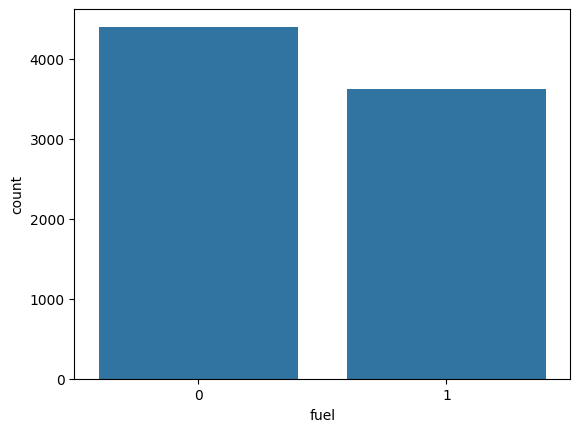

In [129]:
sns.countplot(data = df, x = 'fuel')

<Axes: xlabel='transmission', ylabel='count'>

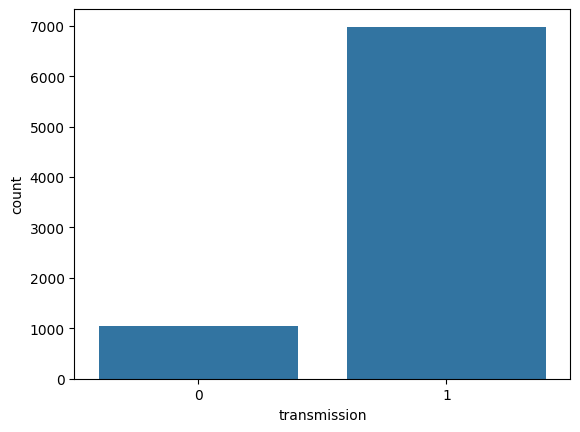

In [130]:
sns.countplot(data = df, x = 'transmission')

<Axes: xlabel='owner', ylabel='count'>

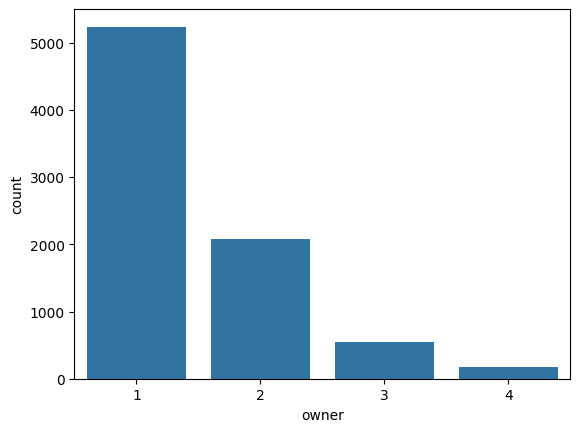

In [131]:
sns.countplot(data = df, x = 'owner')

#### Distribution Plot

<Axes: xlabel='mileage', ylabel='Count'>

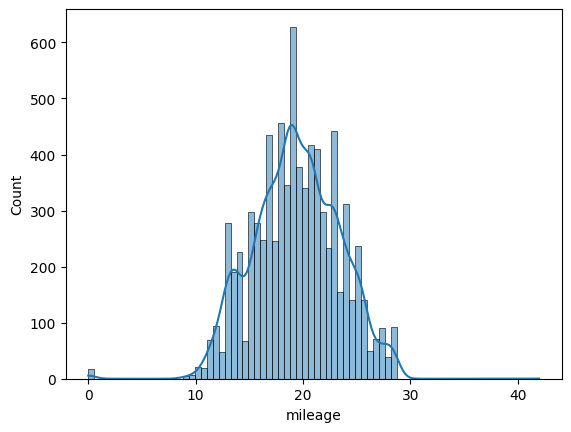

In [132]:
sns.histplot(data = df, x = 'mileage', kde=True)

<Axes: xlabel='brand', ylabel='Count'>

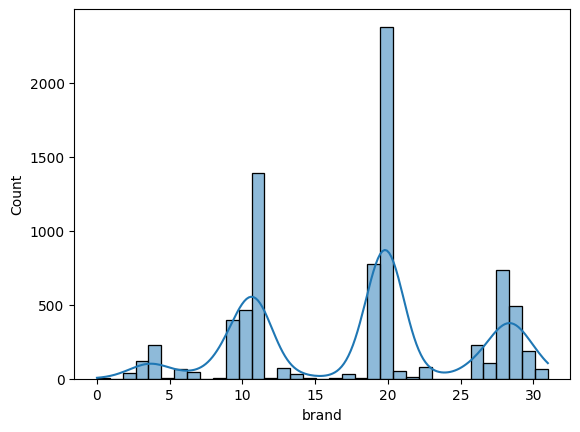

In [133]:
sns.histplot(data = df, x = 'brand', kde=True)

<Axes: xlabel='km_driven', ylabel='Count'>

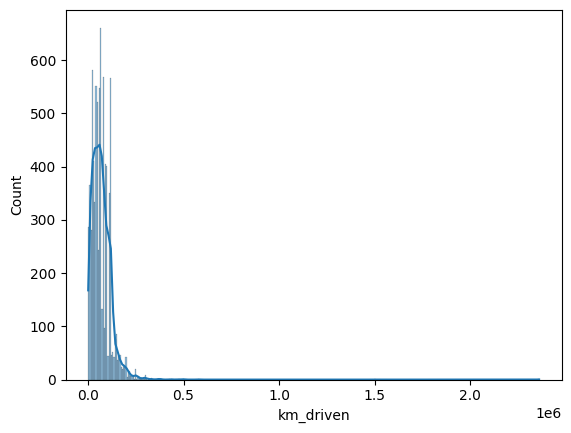

In [134]:
sns.histplot(data = df, x = 'km_driven', kde=True)

<Axes: xlabel='selling_price', ylabel='Count'>

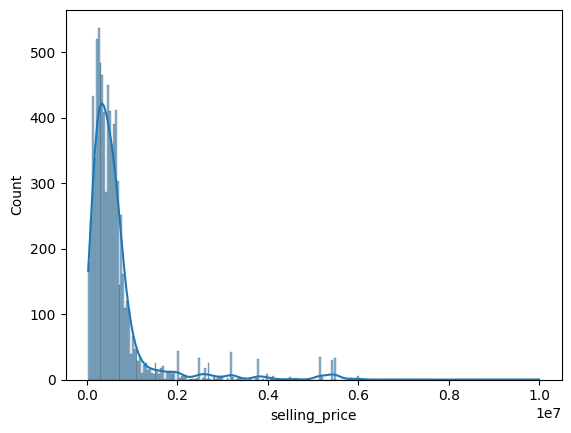

In [135]:
sns.histplot(data = df, x = 'selling_price', kde=True)

#### 3.2. Multivariate Analysis
#### Boxplot

Text(0, 0.5, 'Selling Price')

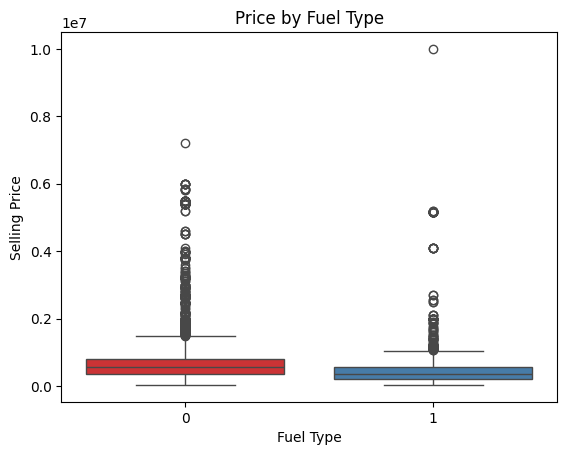

In [136]:
sns.boxplot(data=df, x='fuel', y='selling_price', palette='Set1')
plt.title('Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Selling Price')

Text(0, 0.5, 'Selling Price')

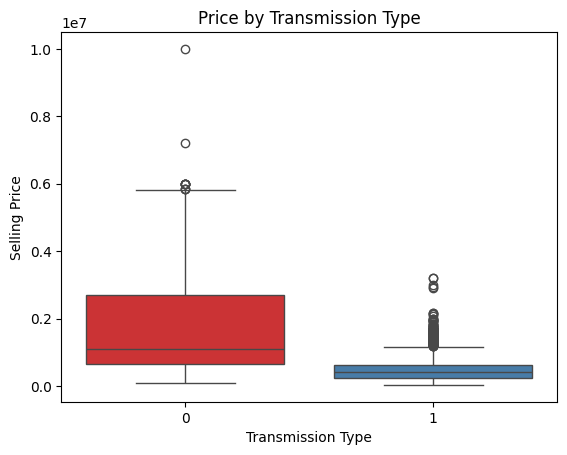

In [137]:
sns.boxplot(data=df, x='transmission', y='selling_price', palette='Set1')
plt.title('Price by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Selling Price')

Text(0, 0.5, 'Selling Price')

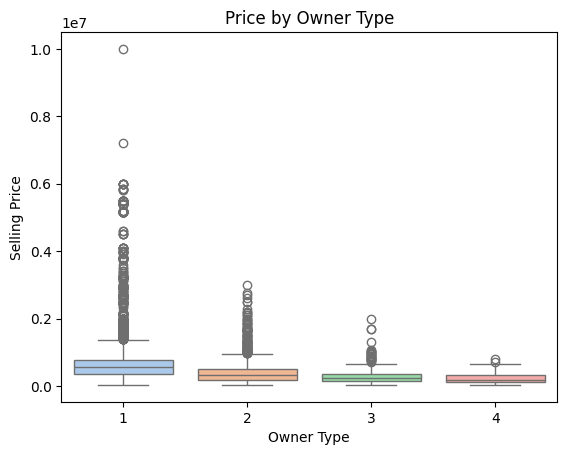

In [138]:
sns.boxplot(data=df, x='owner', y='selling_price', palette='pastel')
plt.title('Price by Owner Type')
plt.xlabel('Owner Type')
plt.ylabel('Selling Price')

Text(0, 0.5, 'Selling Price')

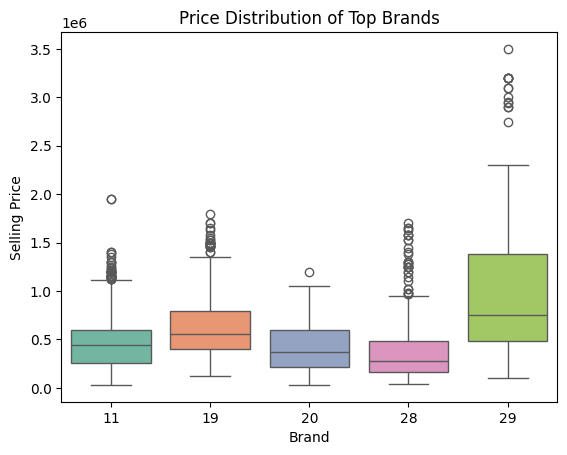

In [139]:
top_brands = df['brand'].value_counts().nlargest(5).index
sns.boxplot(x='brand', y='selling_price', data=df[df['brand'].isin(top_brands)],
            palette='Set2')
plt.title('Price Distribution of Top Brands')
plt.xlabel('Brand')
plt.ylabel('Selling Price')

#### Scatter Plot

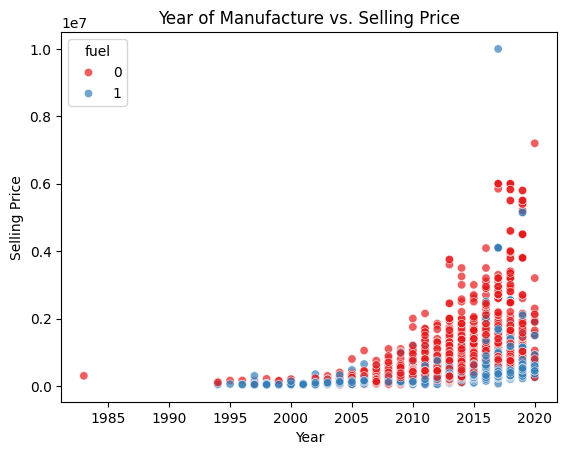

In [140]:
sns.scatterplot(x='year', y='selling_price', data=df, hue='fuel', palette='Set1', alpha=0.7)
plt.title('Year of Manufacture vs. Selling Price')
plt.xlabel('Year')
plt.ylabel('Selling Price')
plt.show()

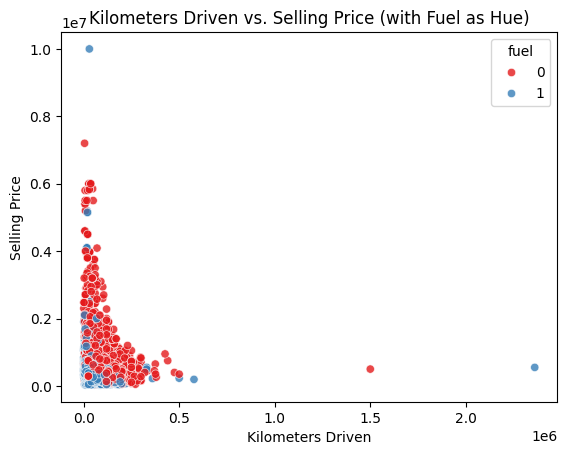

In [141]:
sns.scatterplot(x='km_driven', y='selling_price', data=df, hue='fuel', palette='Set1', alpha=0.8)
plt.title('Kilometers Driven vs. Selling Price (with Fuel as Hue)')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.show()

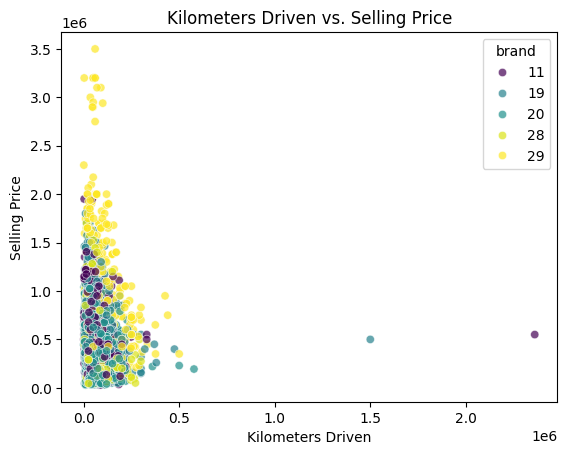

In [142]:
top_brands = df['brand'].value_counts().nlargest(5).index
sns.scatterplot(data=df[df['brand'].isin(top_brands)], x='km_driven', y='selling_price', hue='brand', palette='viridis', alpha=0.7)
plt.title('Kilometers Driven vs. Selling Price')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.show()

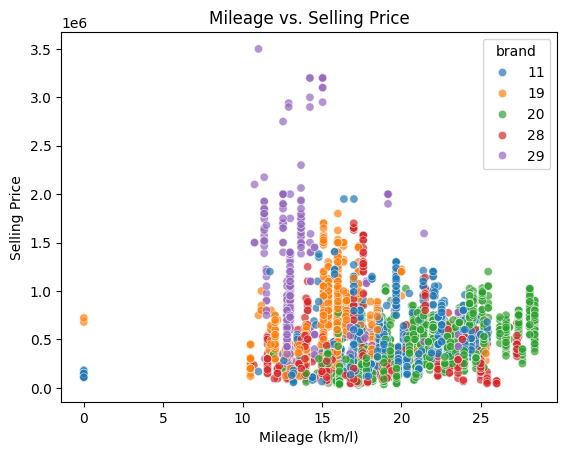

In [143]:
top_brands = df['brand'].value_counts().nlargest(5).index
sns.scatterplot(data=df[df['brand'].isin(top_brands)], x='mileage', y='selling_price', hue='brand', palette='tab10', alpha=0.7)
plt.title('Mileage vs. Selling Price')
plt.xlabel('Mileage (km/l)')
plt.ylabel('Selling Price')
plt.show()

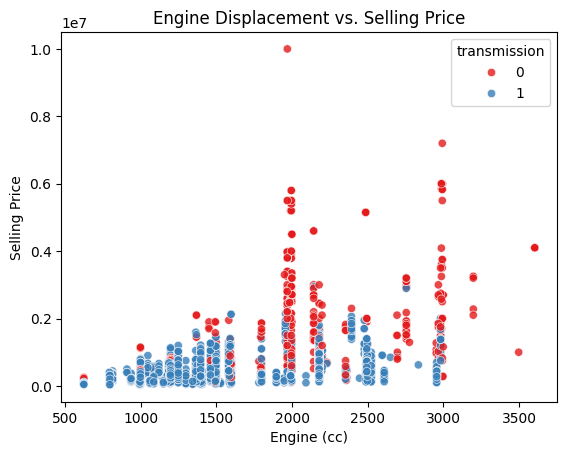

In [144]:
sns.scatterplot(data=df, x='engine', y='selling_price', hue='transmission', palette='Set1', alpha=0.8)
plt.title('Engine Displacement vs. Selling Price')
plt.xlabel('Engine (cc)')
plt.ylabel('Selling Price')
plt.show()

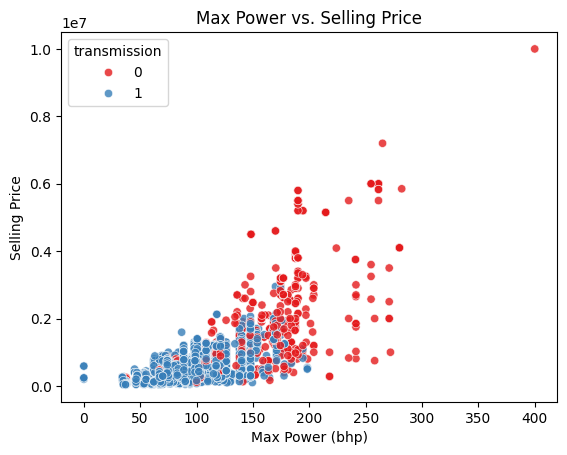

In [145]:
sns.scatterplot(data=df, x='max_power', y='selling_price', hue='transmission', palette='Set1', alpha=0.8)
plt.title('Max Power vs. Selling Price')
plt.xlabel('Max Power (bhp)')
plt.ylabel('Selling Price')
plt.show()

#### Correlation Matrix

<Axes: >

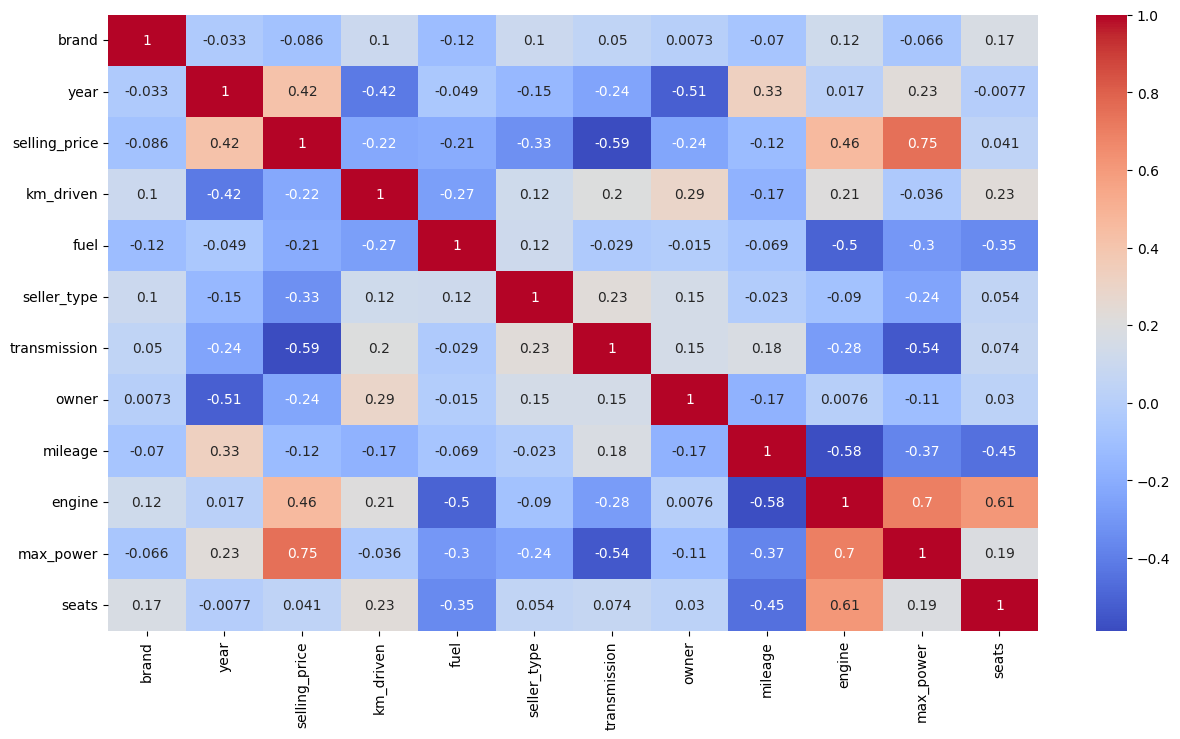

In [146]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

#### Predictive Power Score

<Axes: xlabel='x', ylabel='y'>

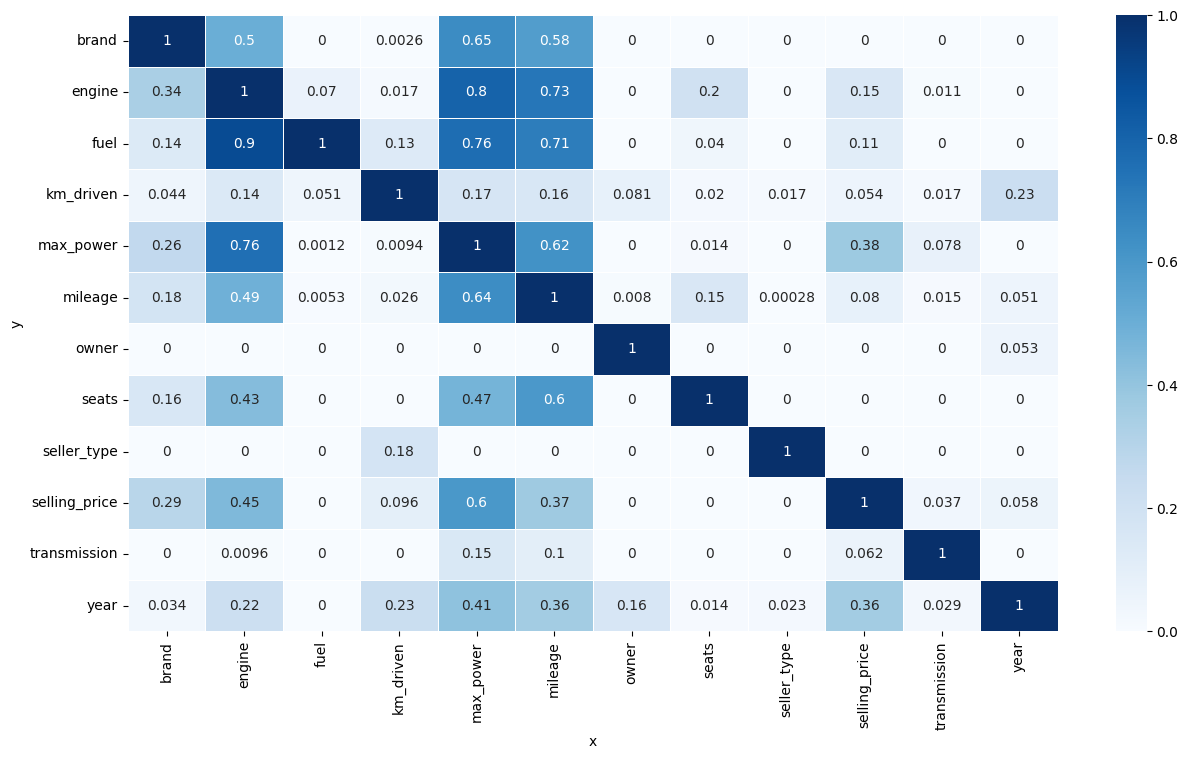

In [147]:
#Importing the ppscore
import ppscore as pps

dfcopy = df.copy()

# Some minor preprocessing is done because seaborn.heatmap unfortunately does not accept tidy data
matrix_df = pps.matrix(dfcopy).pivot(columns='x', index='y', values='ppscore')

# The Predictive power score graph is plotted
plt.figure(figsize = (15,8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## 4. Feature Selection

In [148]:
X = df[['year', 'max_power', 'mileage']] # Important Features
y = np.log(df['selling_price']) # Target Variable

### Train & Test Split

In [149]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [150]:
df.describe()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
count,8028.00,8028.00,8028.00,8028.00,8028.00,8028.00,8028.00,8028.00,7814.00,7814.00,7820.00,7814.00
mean,18.00,2013.82,640393.65,69773.14,0.45,0.89,0.87,1.46,19.39,1462.91,91.82,5.42
std,7.39,4.03,802701.55,56644.19,0.50,0.40,0.34,0.72,4.00,504.76,35.80,0.96
min,0.00,1983.00,29999.00,1000.00,0.00,0.00,0.00,1.00,0.00,624.00,0.00,2.00
25%,11.00,2011.00,260000.00,35000.00,0.00,1.00,1.00,1.00,16.78,1197.00,68.85,5.00
50%,20.00,2015.00,450000.00,60000.00,0.00,1.00,1.00,1.00,19.30,1248.00,82.40,5.00
75%,20.00,2017.00,680000.00,98000.00,1.00,1.00,1.00,2.00,22.32,1582.00,102.00,5.00
max,31.00,2020.00,10000000.00,2360457.00,1.00,2.00,1.00,4.00,42.00,3604.00,400.00,14.00


In [151]:
print("Log-transformed target stats:", y.describe())

Log-transformed target stats: count   8028.00
mean      12.98
std        0.84
min       10.31
25%       12.47
50%       13.02
75%       13.43
max       16.12
Name: selling_price, dtype: float64


In [152]:
df.to_csv("Cleaned_Cars.csv", sep=",", index=False, encoding='utf-8') # Saving the cleaned dataset

In [153]:
# Check for negative prices (should be none after log transform)
if (df['selling_price'] <= 0).any():
    print("Warning: Found non-positive prices before log transform!")
    # Filter them out
    df = df[df['selling_price'] > 0]
    y = np.log(df['selling_price'])

## 5. Data Preprocessing

In [154]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6422, 3)
X_test shape: (1606, 3)
y_train shape: (6422,)
y_test shape: (1606,)


In [155]:
X_train[['year', 'max_power', 'mileage']].isna().sum()

year           0
max_power    165
mileage      171
dtype: int64

In [156]:
X_test[['year', 'max_power', 'mileage']].isna().sum()

year          0
max_power    43
mileage      43
dtype: int64

In [157]:
y_train.isna().sum()

np.int64(0)

In [158]:
y_test.isna().sum()

np.int64(0)

In [159]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6422 entries, 2948 to 7275
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       6422 non-null   int64  
 1   max_power  6257 non-null   float64
 2   mileage    6251 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 200.7 KB


#### Verifying the distribution of all the missing values

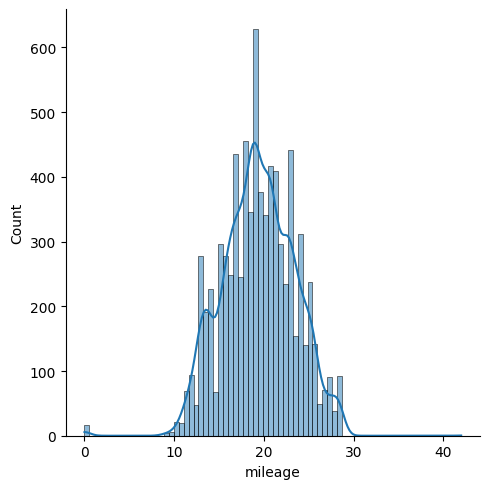

In [160]:
sns.displot(data=df,x='mileage', kde=True)

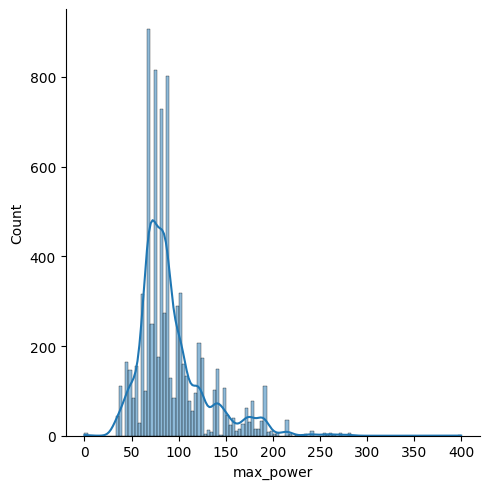

In [161]:
sns.displot(data=df, x='max_power', kde=True)

In [162]:
# Continuous features → use median
X_train['mileage'].fillna(X_train['mileage'].mean(), inplace=True)
X_test['mileage'].fillna(X_train['mileage'].mean(), inplace=True)  # use train's mean, not test's own!

X_train['max_power'].fillna(X_train['max_power'].mean(), inplace=True)
X_test['max_power'].fillna(X_train['max_power'].mean(), inplace=True)

In [163]:
X_train['mileage'].mean()

np.float64(19.383089105743082)

In [164]:
X_train['max_power'].mean()

np.float64(91.78763944382293)

In [165]:
# Remove rows with NA values in y_train and y_test
y_train_rows_with_na = y_train.isna()
y_train = y_train[~y_train_rows_with_na]
X_train = X_train[~y_train_rows_with_na]

y_test_rows_with_na = y_test.isna()
X_test = X_test[~y_test_rows_with_na]
y_test = y_test[~y_test_rows_with_na]

In [166]:
X_train[['year', 'max_power', 'mileage']].isna().sum() # Checking for missing values in feature variables

year         0
max_power    0
mileage      0
dtype: int64

In [167]:
X_test[['year', 'max_power', 'mileage']].isna().sum() # Checking for missing values in feature variables

year         0
max_power    0
mileage      0
dtype: int64

In [168]:
y_test.isna().sum(), y_train.isna().sum() # Checking for missing values in target variables

(np.int64(0), np.int64(0))

#### 5.1. Checking Outliers

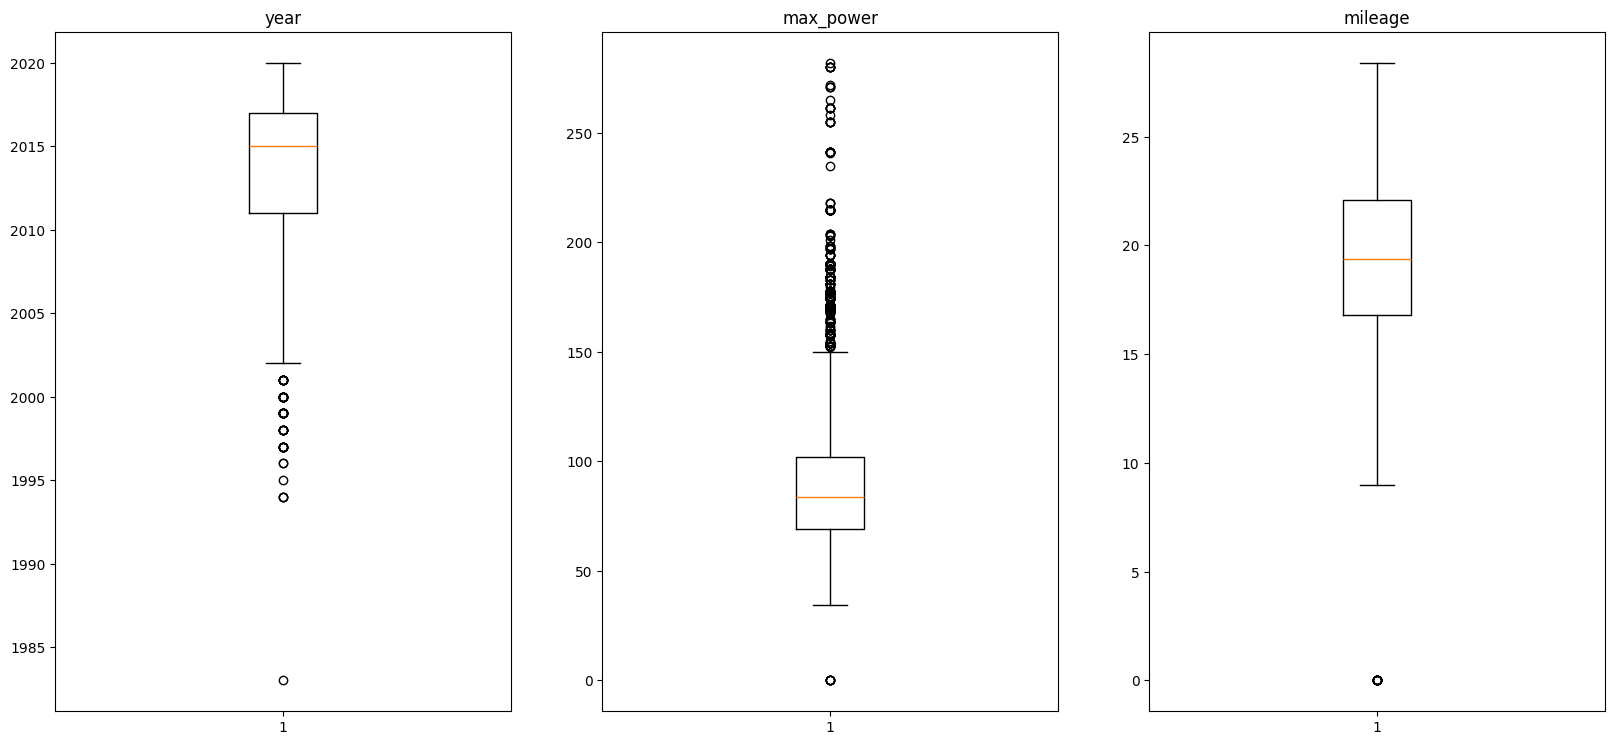

In [169]:
col_dict = {
    'year': 1,
    'max_power': 2,
    'mileage': 3
}

# Detecting outliers in each variable using box plots.
plt.figure(figsize=(20, 30))

#Looping through col_dict
for variable, i in col_dict.items():
    # Creating subplots within a large figures. the arguments 3 and 3 spethat the figure should have a grid of 3 rows and 3 columns of subplots. While the argument i specifies the current position of the subplot within the grid, based on the values from col_dict
    plt.subplot(3, 3, i)
    plt.boxplot(X_train[variable])
    # Setting the title of the current subplot to the name of the column (variable) being visualized.
    plt.title(variable)

plt.show()

In [170]:
# Defining a function to calculate the outliers in each features as it will decrease data quality in turn the efficiency of our model will also be negatively impacted
def outlier_count(col, data = X_train):
    
    # Calculating Q1 and Q3
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculating the interquartile range
    iqr = q75 - q25
    
    # Calculating the minimum and maximum value
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    # Counting the number of outliers, which are the data that are less than min_val or more than max_val which have been calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # Calculating the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    # Checking to see if any outliers are present and printing information about the same
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [171]:
# Printing all the outliers in each of the features
for col in X_train.columns:
    outlier_count(col, data=X_train)  # Pass the DataFrame, not the numpy array


---------------year---------------

Number of outliers: 63
Percent of data that is outlier: 0.98%

---------------max_power---------------

Number of outliers: 459
Percent of data that is outlier: 7.15%

---------------mileage---------------

Number of outliers: 16
Percent of data that is outlier: 0.25%


#### 5.2. Scaling

In [172]:
from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [173]:
# Standardization (only on numeric values now!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [174]:
# Verifying the shape of all X_train, X_test, Y_train and Y_test

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (6422, 3)
Shape of X_test:  (1606, 3)
Shape of y_train:  (6422,)
Shape of y_test:  (1606,)


## 6. Modeling

In [175]:
# Using the Random Forest Regressor as it is a regression based problem
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(random_state= None)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)
print(y_hat)
feature_importances = rf.feature_importances_
print("MSE: ", mean_squared_error(y_test, y_hat))
print("r2: ", r2_score(y_test, y_hat))

[12.36346988 13.80127304 12.77804715 ... 10.68667273 13.42937903
 12.87221174]
MSE:  0.046771005326291686
r2:  0.9343234277403432


#### 6.1. Cross-Validation

In [176]:
# Performing Cross validation to compare the efficincy of different algorithms in our model

# Importing the libraries for model evaluation
from sklearn.ensemble import RandomForestRegressor #we are using regression models
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


# models that we will be using, putting them in a list
models = [LinearRegression(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(random_state = 0), 
              RandomForestRegressor(n_estimators = 100, random_state = 0)]

# The names of the models
model_names = ["Linear Regression", "SVR", "KNeighbors Regressor", "Decision-Tree Regressor", "Random-Forest Regressor"]

In [177]:
from sklearn.model_selection import KFold, cross_val_score

#lists for keeping mse
train_mse = []
test_mse = []

# Defining the cross-validation strategy using KFold with 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for i, model in enumerate(models):
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print(f"{model_names[i]} - Score: {scores}; Mean: {scores.mean()}")

Linear Regression - Score: [-0.11553182 -0.11583924 -0.12627649 -0.1172396  -0.12134433]; Mean: -0.11924629823210069
SVR - Score: [-0.08912476 -0.08907213 -0.08912615 -0.07562109 -0.09048698]; Mean: -0.08668622318889481
KNeighbors Regressor - Score: [-0.06705534 -0.07073945 -0.07440617 -0.06407192 -0.07471159]; Mean: -0.0701968936557621
Decision-Tree Regressor - Score: [-0.06380688 -0.06533069 -0.06646452 -0.06979767 -0.06945582]; Mean: -0.06697111444304196
Random-Forest Regressor - Score: [-0.05142051 -0.05697145 -0.05730323 -0.05267362 -0.0577098 ]; Mean: -0.05521572296574666


#### 6.2. Grid Search

In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from joblib import parallel_backend

param_grid = {
    'max_depth': [5, 10, None],
    'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 50, 100],
}

# Creating the Random Forest Regressor Object
rfr = RandomForestRegressor(random_state = 1)

# Creating the Random Forest Regressor instance with a fixed random state for reproducibility
grid = GridSearchCV(estimator = rfr, # Using the Random Forest Regressor instance
                    param_grid = param_grid, # Testing the different combinations of parameters from the param_grid
                    cv = kfold, # Using the defined KFold cross-validation strategy
                    n_jobs = 1, # Using a single CPU core
                    return_train_score=True, # Including training scores in the results
                    refit=True, # Refitting the best model on the full dataset after finding the best parameters
                    scoring='neg_mean_squared_error') # Using negative mean squared error as the scoring metric
# Fit GridSearchCV using threading backend to keep some parallelism without process-based multiprocessing
with parallel_backend('threading'):
    # Fitting the grid search to the training data
    grid.fit(X_train, y_train)

# Getting the best parameters and best negative MSE score
best_params = grid.best_params_ # Best combination of parameters found during the search
best_mse = -grid.best_score_  # Best negative MSE score; negate to get actual MSE value

# Printing the results
print("Best Parameters:", best_params)
print("Best MSE:", best_mse)

Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best MSE: 0.05492950969105235


## 7. Testing

In [179]:
# Storing the predicted values for the target found by the best model based on GridSearchCV
y_hat = grid.predict(X_test)

# Calculating the MSE
print("MSE: ", mean_squared_error(y_test, y_hat))
print("R2: ", r2_score(y_test, y_hat))

MSE:  0.04655216620721056
R2:  0.9346307250309894


In [180]:
# Comparing the actual and predicted selling prices
# Setting the desired decimal precision for display
pd.options.display.float_format = '{:.2f}'.format  # Set to 2 decimal places

pd.DataFrame({'Actual Price:': np.exp(y_test), 'Predicted Price:': np.exp(y_hat)})

,Actual Price:,Predicted Price:
5871,225000.00,237838.75
5961,900000.00,987512.89
3032,320000.00,354299.49
6450,650000.00,488192.51
318,520000.00,638489.46
...,...,...
4609,440000.00,461461.98
2943,700000.00,913106.87
2441,60000.00,44028.81
921,750000.00,671434.14


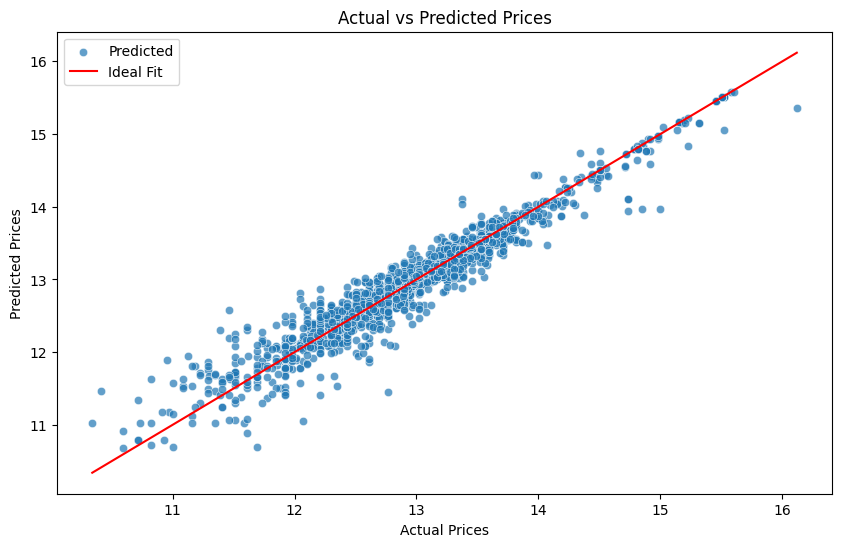

In [181]:
plt.figure(figsize=(10,6))

# Scatterplot of actual vs predicted
sns.scatterplot(x=y_test, y=y_hat, alpha=0.7, label='Predicted')

# Plot reference line y = x
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', label='Ideal Fit')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()


## 8. Analysis: Feature Importance

As our actual and predicted prices are very near. The next step is to analyze the importance of each feature in the model. Extracting which feature is important for prediction can help us interpret the results. There are several ways: algorithm, permutation, and shap. Note that these techniques can be mostly applied to most algorithms.

#### Algorithm way

Some ML algorithms provide feature importance score after you fit the model

In [182]:
#stored in this variable
#note that grid here is random forest
rf = grid.best_estimator_
rf.feature_importances_

array([0.47348874, 0.47071552, 0.05579574])

<BarContainer object of 3 artists>

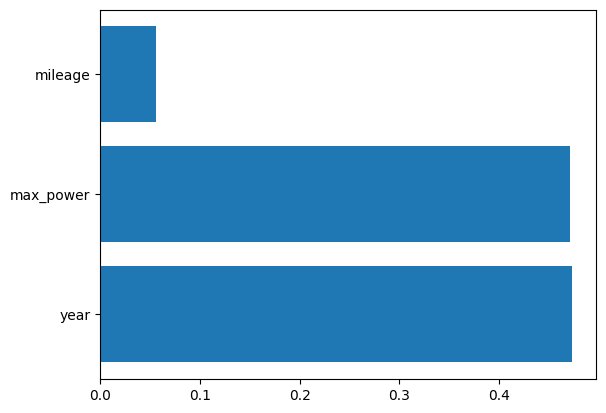

In [183]:
plt.barh(X.columns, rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

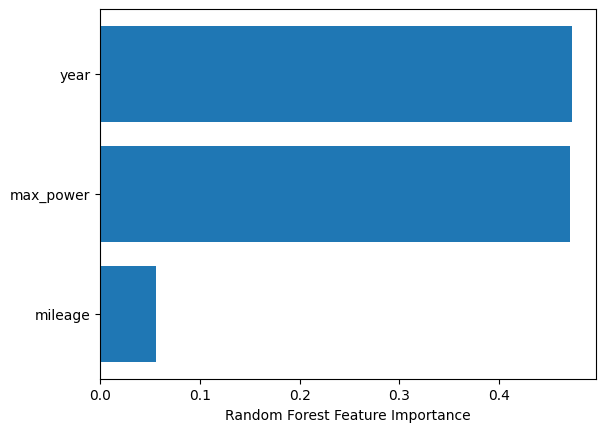

In [184]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Permutation way

This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one.

*Note*: The permutation based importance is computationally expensive. The permutation based method can have problem with highly-correlated features, it can report them as unimportant.

Text(0.5, 0, 'Random Forest Feature Importance')

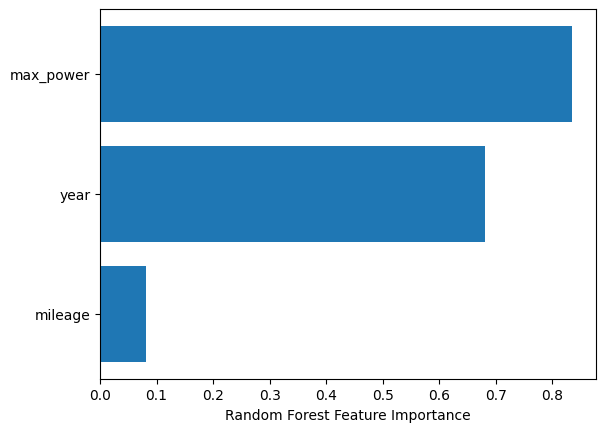

In [185]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X_test, y_test)

#let's plot
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Shap way

The SHAP interpretation can be used (it is model-agnostic) to compute the feature importances. It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction. It can be easily installed (<code>uv pip install shap</code>) 

In [186]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

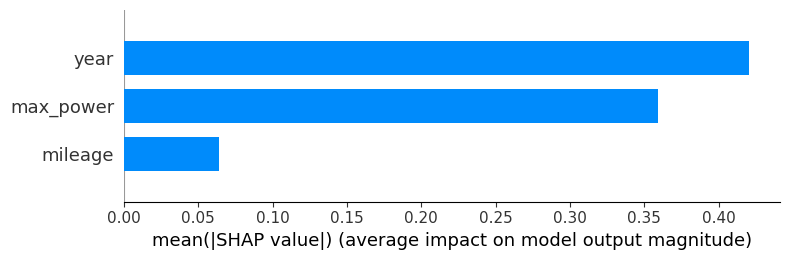

In [187]:
#shap plot
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = X.columns)

## 9. Inference


To provide inference service or deploy, it's best to save the model for latter use.

In [188]:
import os
import pickle

# Create directory if it doesn't exist
os.makedirs('Model', exist_ok=True)

# Saving the model to disk
filename = 'Model/car_prediction.model'
pickle.dump(grid, open(filename, 'wb'))
scaler_path = 'Model/car_scalar.model'
feature_importance_path = 'Model/feature_importance.model'
pickle.dump(scaler, open(scaler_path, 'wb'))
pickle.dump(rfr, open(feature_importance_path, 'wb'))
print(filename)
print(scaler_path)
print(feature_importance_path)

Model/car_prediction.model
Model/car_scalar.model
Model/feature_importance.model


In [189]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
scalar_model = pickle.load(open(scaler_path, 'rb'))
feature_importances_model = pickle.load(open(feature_importance_path, 'rb'))

## 10. Example

In [206]:
sample = df[['year', 'max_power', 'mileage']].iloc[1].to_frame().T
sample

,year,max_power,mileage
1,2014.00,103.52,21.14


In [207]:
sample = scalar_model.transform(sample)
sample

array([[2014.  ,  103.52,   21.14]])

In [208]:
predicted_selling_price = loaded_model.predict(sample)
np.set_printoptions(precision=2)
print("Predicted Price: ", str(np.exp(predicted_selling_price)))

Predicted Price:  [4668236.4]


In [209]:
feature_importances_model

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# ------------------------- Task 2-----------------------------